In [5]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import pandas_profiling 
import seaborn as sns


from datetime import datetime

import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
train = pd.read_csv('train.csv')
feature = pd.read_csv('features.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
writer=pd.ExcelWriter('Walmart_sales_pred_out.xlsx', engine='xlsxwriter')

In [7]:
train_bt = pd.merge(train,stores) 
train = pd.merge(train_bt,feature)
#
test_bt = pd.merge(test,stores)
test= pd.merge(test_bt,feature)

In [8]:
train.head(2)          

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [9]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [10]:
print (train.info())
print ("*****************************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None
*****************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-nu

In [11]:
numeric_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object']]
#numerical
train_num=train[numeric_var_train]
#categorical
train_cat=train[cat_var_train]
print (numeric_var_train)
print (cat_var_train) 

['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


In [12]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
 
num_summary=train_num.apply(lambda x: var_summary(x)).T
num_summary.to_excel(writer,'Numeric_variable Summary',index=True)
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,421570.0,0.0,9.359084e+06,22.200546,22.00000,12.785297,1.634638e+02,1.000,1.000000,3.000000,5.000000,11.000000,22.00000,33.000000,40.000000,43.000000,45.000000,45.000000
Dept,421570.0,0.0,1.865882e+07,44.260317,37.00000,30.492054,9.297654e+02,1.000,1.000000,4.000000,7.000000,18.000000,37.00000,74.000000,92.000000,95.000000,98.000000,99.000000
Weekly_Sales,421570.0,0.0,6.737219e+09,15981.258123,7612.03000,22711.183519,5.157979e+08,-4988.940,5.000000,59.974500,291.097000,2079.650000,7612.03000,20205.852500,42845.673000,61201.951000,106479.586000,693099.360000
Size,421570.0,0.0,5.764039e+10,136727.915739,140167.00000,60980.583328,3.718632e+09,34875.000,34875.000000,39690.000000,39910.000000,93638.000000,140167.00000,202505.000000,204184.000000,206302.000000,219622.000000,219622.000000
Temperature,421570.0,0.0,2.533217e+07,60.090059,62.09000,18.447931,3.403262e+02,-2.060,18.300000,27.310000,33.980000,46.680000,62.09000,74.280000,83.580000,87.270000,92.810000,100.140000
Fuel_Price,421570.0,0.0,1.416908e+06,3.361027,3.45200,0.458515,2.102356e-01,2.472,2.565000,2.653000,2.720000,2.933000,3.45200,3.738000,3.917000,4.029000,4.202000,4.468000
MarkDown1,150681.0,270889.0,1.091898e+09,7246.420196,5347.45000,8291.221345,6.874435e+07,0.270,17.760000,149.190000,375.200000,2240.270000,5347.45000,9210.900000,15282.470000,21801.350000,41524.030000,88646.760000
MarkDown2,111248.0,310322.0,3.709708e+08,3334.628621,192.00000,9475.357325,8.978240e+07,-265.760,-0.990000,1.950000,6.980000,41.600000,192.00000,1926.940000,8549.740000,16497.470000,50366.600000,104519.540000
MarkDown3,137091.0,284479.0,1.973317e+08,1439.421384,24.60000,9623.078290,9.260364e+07,-29.100,0.060000,0.650000,1.650000,5.080000,24.60000,103.990000,400.090000,1059.900000,63143.290000,141630.610000
MarkDown4,134967.0,286603.0,4.566161e+08,3383.168256,1481.31000,6292.384031,3.959410e+07,0.220,3.970000,28.760000,108.710000,504.220000,1481.31000,3595.040000,7871.420000,12645.960000,35785.260000,67474.850000


In [13]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=train_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,421570,421570
NMISS,0,0
ColumnsNames,2011-12-23 3027 2011-11-25 3021 2011-12-...,A 215478 B 163495 C 42597 Name: Type...


In [14]:
numeric_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['object']]
test_num=test[numeric_var_test]
test_cat=test[cat_var_test]
print (numeric_var_test)
print (cat_var_test)

['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


In [15]:
num_summary=test_num.apply(lambda x: var_summary(x)).T
#num_summary.to_excel(writer,'Numeric_variable Summary',index=True)
num_summary.head()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,115064.0,0.0,2.558817e+06,22.238207,22.000,12.809930,1.640943e+02,1.000,1.000,3.000,5.000,11.000,22.000,33.000,40.000,43.000,45.000,45.000
Dept,115064.0,0.0,5.101883e+06,44.339524,37.000,30.656410,9.398155e+02,1.000,1.000,4.000,7.000,18.000,37.000,74.000,92.000,95.000,98.000,99.000
Size,115064.0,0.0,1.570597e+10,136497.688921,140167.000,61106.926438,3.734056e+09,34875.000,34875.000,39690.000,39910.000,93638.000,140167.000,202505.000,204184.000,206302.000,219622.000,219622.000
Temperature,115064.0,0.0,6.206760e+06,53.941804,54.470,18.724153,3.505939e+02,-7.290,11.440,23.980,29.970,39.820,54.470,67.350,79.480,83.820,92.140,101.950
Fuel_Price,115064.0,0.0,4.121070e+05,3.581546,3.606,0.239442,5.733244e-02,2.872,2.957,3.161,3.227,3.431,3.606,3.766,3.866,3.951,4.079,4.125


In [16]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=test_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,115064,115064
NMISS,0,0
ColumnsNames,2012-12-21 3002 2012-12-07 2989 2012-12-...,"A 58713 B 44500 C 11851 Name: Type, d..."


In [17]:
#pandas_profiling.ProfileReport(train)

In [18]:
#pandas_profiling.ProfileReport(test)

In [19]:
train_corr=pd.DataFrame(train.corr())
train_corr.to_excel(writer,'Train_Data Corr',index=True)
train_corr.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828,-0.002312,-0.000120,0.085251,0.024130,0.060385,0.045414,0.090362,-0.020921,-0.025864
IsHoliday,-0.000548,0.000916,0.012774,1.000000,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238


In [20]:
test_corr=pd.DataFrame(test.corr())
#test_corr.to_excel(writer,'Test_Data Corr',index=True)
test_corr.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.019627,-0.001166,-0.186845,-0.043495,0.153425,-0.091707,-0.041370,-0.025177,0.010331,0.010419,-0.214872,0.250321
Dept,0.019627,1.000000,0.001249,0.001502,0.003970,0.000554,-0.002353,0.001292,0.000247,0.002510,0.000776,-0.006336,0.004087
IsHoliday,-0.001166,0.001249,1.000000,-0.000443,-0.187428,-0.126443,0.355257,0.265402,0.496062,0.289700,-0.019386,-0.001475,0.010288
Size,-0.186845,0.001502,-0.000443,1.000000,-0.061256,0.055088,0.309614,0.157526,0.050088,0.155448,0.103681,-0.002916,-0.001988
Temperature,-0.043495,0.003970,-0.187428,-0.061256,1.000000,0.073938,-0.168899,-0.324280,-0.049771,-0.059583,0.003937,0.280861,0.022136


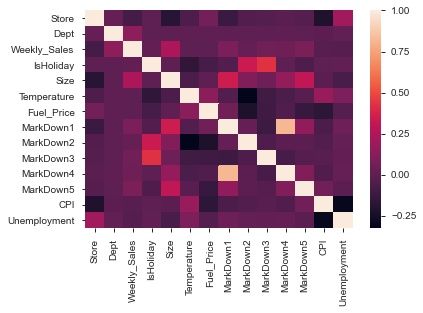

In [21]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(train.corr())

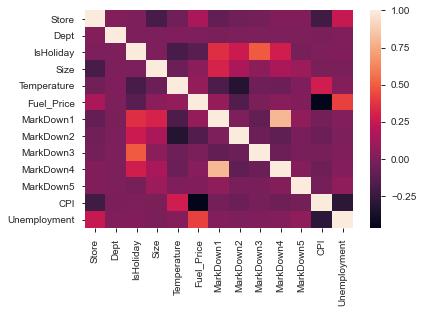

In [22]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(test.corr())

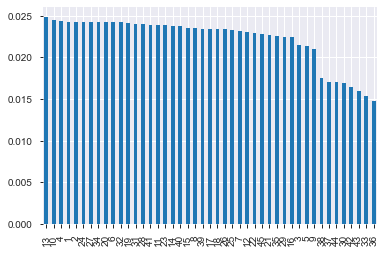

In [23]:
train['Store'].value_counts(normalize=True).plot(kind = 'bar',fig=(4,5))

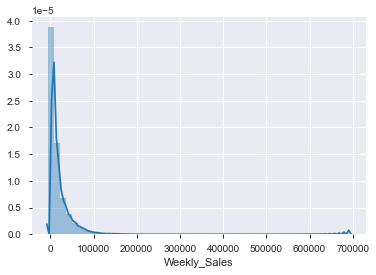

In [24]:
sns.distplot(train.Weekly_Sales)

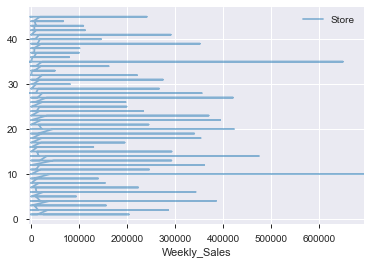

In [25]:
train.plot(kind='line', x='Weekly_Sales', y='Store', alpha=0.5)

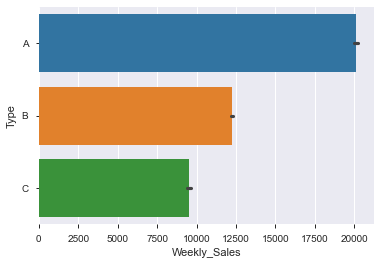

In [26]:
sns.barplot(x=train["Weekly_Sales"],y=train["Type"])

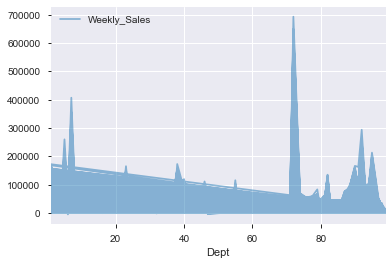

In [27]:
train.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=1.5,fig=(4,5))

In [28]:
#Missing VAlues
print (train.isnull().sum())
print ("*"*30)
print (test.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64
******************************
Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


In [29]:
test['CPI']=test.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
test['Unemployment']=test.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))

In [30]:
train=train.fillna(0)
test=test.fillna(0)

In [31]:
print (train.isnull().sum())
print ("*"*30)
print (test.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64
******************************
Store           0
Dept            0
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


In [32]:
train.Weekly_Sales=np.where(train.Weekly_Sales>100000, 100000,train.Weekly_Sales)

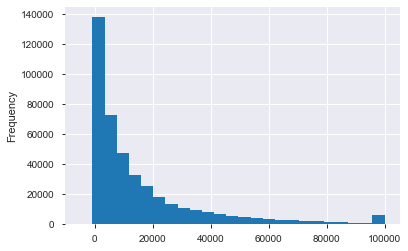

In [33]:
train.Weekly_Sales.plot.hist(bins=25)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       421570 non-null float64
MarkDown2       421570 non-null float64
MarkDown3       421570 non-null float64
MarkDown4       421570 non-null float64
MarkDown5       421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 71.9+ MB


In [35]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [36]:
# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

test['Date_dayofweek'] =test['Date'].dt.dayofweek
test['Date_month'] =test['Date'].dt.month 
test['Date_year'] =test['Date'].dt.year
test['Date_day'] =test['Date'].dt.day 

In [37]:
print (train.Type.value_counts())
print ("*"*30)
print (test.Type.value_counts())

A    215478
B    163495
C     42597
Name: Type, dtype: int64
******************************
A    58713
B    44500
C    11851
Name: Type, dtype: int64


In [38]:
print (train.IsHoliday.value_counts())
print ("*"*30)
print (test.IsHoliday.value_counts())

False    391909
True      29661
Name: IsHoliday, dtype: int64
******************************
False    106136
True       8928
Name: IsHoliday, dtype: int64


In [39]:
train_test_data = [train, test]

In [40]:
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_test_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

In [41]:
# comnverting categoricail holidays date into numerical
type_mapping = {False: 0, True: 1}
for dataset in train_test_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

In [42]:
train['Super_Bowl'] = np.where((train['Date']==datetime(2010, 2, 12)) | (train['Date']==datetime(2011, 2, 11)) | (train['Date']==datetime(2012, 2, 10)) | (train['Date']==datetime(2013, 2, 8)),1,0)
train['Labour_Day'] = np.where((train['Date']==datetime(2010, 9, 10)) | (train['Date']==datetime(2011, 9, 9)) | (train['Date']==datetime(2012, 9, 7)) | (train['Date']==datetime(2013, 9, 6)),1,0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)
#........................................................................
test['Super_Bowl'] = np.where((test['Date']==datetime(2010, 2, 12)) | (test['Date']==datetime(2011, 2, 11)) | (test['Date']==datetime(2012, 2, 10)) | (test['Date']==datetime(2013, 2, 8)),1,0)
test['Labour_Day'] = np.where((test['Date']==datetime(2010, 9, 10)) | (test['Date']==datetime(2011, 9, 9)) | (test['Date']==datetime(2012, 9, 7)) | (test['Date']==datetime(2013, 9, 6)),1,0)
test['Thanksgiving'] = np.where((test['Date']==datetime(2010, 11, 26)) | (test['Date']==datetime(2011, 11, 25)) | (test['Date']==datetime(2012, 11, 23)) | (test['Date']==datetime(2013, 11, 29)),1,0)
test['Christmas'] = np.where((test['Date']==datetime(2010, 12, 31)) | (test['Date']==datetime(2011, 12, 30)) | (test['Date']==datetime(2012, 12, 28)) | (test['Date']==datetime(2013, 12, 27)),1,0)


In [43]:
# Altering the isHoliday value depending on these new holidays...
train['IsHoliday']=train['IsHoliday']|train['Super_Bowl']|train['Labour_Day']|train['Thanksgiving']|train['Christmas']
test['IsHoliday']=test['IsHoliday']|test['Super_Bowl']|test['Labour_Day']|test['Thanksgiving']|test['Christmas']

In [44]:
print (train.Christmas.value_counts())
print (train.Super_Bowl.value_counts())
print (train.Thanksgiving.value_counts())
print (train.Labour_Day.value_counts())
print (test.Christmas.value_counts())
print (test.Super_Bowl.value_counts())
print (test.Thanksgiving.value_counts())
print (test.Labour_Day.value_counts())

0    415624
1      5946
Name: Christmas, dtype: int64
0    412675
1      8895
Name: Super_Bowl, dtype: int64
0    415611
1      5959
Name: Thanksgiving, dtype: int64
0    412709
1      8861
Name: Labour_Day, dtype: int64
0    112076
1      2988
Name: Christmas, dtype: int64
0    112100
1      2964
Name: Super_Bowl, dtype: int64
0    112088
1      2976
Name: Thanksgiving, dtype: int64
0    115064
Name: Labour_Day, dtype: int64


In [45]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant..
# Droping the Extra holiday variables because its redundant..
dp=['Super_Bowl','Labour_Day','Thanksgiving','Christmas']
train.drop(dp,axis=1,inplace=True)
test.drop(dp,axis=1,inplace=True)

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
Store             421570 non-null int64
Dept              421570 non-null int64
Date              421570 non-null datetime64[ns]
Weekly_Sales      421570 non-null float64
IsHoliday         421570 non-null int64
Type              421570 non-null int64
Size              421570 non-null int64
Temperature       421570 non-null float64
Fuel_Price        421570 non-null float64
MarkDown1         421570 non-null float64
MarkDown2         421570 non-null float64
MarkDown3         421570 non-null float64
MarkDown4         421570 non-null float64
MarkDown5         421570 non-null float64
CPI               421570 non-null float64
Unemployment      421570 non-null float64
Date_dayofweek    421570 non-null int64
Date_month        421570 non-null int64
Date_year         421570 non-null int64
Date_day          421570 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(9)
memory usag

In [47]:
#Since we have imputed markdown variables therefore we will not be removing the all markdown variables
#Removing MarkDown5 because its Highly Skewe
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)
test=test.drop(features_drop, axis=1)

In [48]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,4,2,2010,5


In [49]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2012-11-02,0,1,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,4,11,2012,2
1,1,2,2012-11-02,0,1,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,4,11,2012,2


In [50]:
#### train X= Exery thing except Weekly_Sales
train_X=train.drop(['Weekly_Sales','Date'], axis=1)

#### train Y= Only Weekly_Sales 
train_y=train['Weekly_Sales'] 
test_X=test.drop('Date',axis=1).copy()

train_X.shape, train_y.shape, test_X.shape

((421570, 15), (421570,), (115064, 15))

In [51]:
## Methood 1..
clf = LinearRegression()
clf.fit(train_X, train_y)
y_pred_linear=clf.predict(test_X)
acc_linear=round( clf.score(train_X, train_y) * 100, 2)
print ('scorbe:'+str(acc_linear) + ' percent')

scorbe:8.86 percent


In [53]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
acc_rf= round(clf.score(train_X, train_y) * 100, 2)
print ("Accuracy: %i %% \n"%acc_rf)

KeyboardInterrupt: 

In [ ]:
clf=DecisionTreeRegressor()
clf.fit(train_X, train_y)
y_pred_dt= clf.predict(test_X)
acc_dt = round( clf.score(train_X, train_y) * 100, 2)
print (str(acc_dt) + ' percent')

In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest','Decision Tree'],
    
    'Score': [acc_linear, acc_rf,acc_dt]
    })

models.sort_values(by='Score', ascending=False)

In [ ]:
# Prediction value using Random Forest model..
submission = pd.DataFrame({
        "Store_Dept_Date": test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
        "Weekly_Sales": y_pred_rf
    })

submission.to_csv('weekly_sales predicted.csv', index=False)
submission.to_excel(writer,'Weekly_sales Pred',index=False)

In [ ]:
submission.head()